<a href="https://colab.research.google.com/github/h4ck4l1/datasets/blob/main/NLP_with_RNN_and_Attention/transformers_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys,warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")
if "google.colab" in sys.modules:
    %pip install "tensorflow-text==2.13.0"
    %pip install -U kaleido
from IPython.display import clear_output
from zipfile import ZipFile
from typing import Literal
import shutil
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tftext
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_dark"
import matplotlib.pyplot as plt
%matplotlib inline
tf.get_logger().setLevel("ERROR")
if "google.colab" not in sys.modules:
    gpus = tf.config.list_physical_devices("GPU")
    tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=9000)])
clear_output()

In [2]:
if "google.colab" in sys.modules:
    url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    file_path = keras.utils.get_file(fname="spa-eng.zip",origin=url,extract=True)
    with ZipFile(file_path,"r") as f:
        f.extractall("spa-eng")
    with open("spa-eng/spa-eng/spa.txt","r") as f:
        text = f.read()
else:
    with open("spa-eng/spa-eng/spa.txt","r") as f:
        text = f.read()

en_text,es_text = zip(*[line.split("\t") for line in text.splitlines()])
for en,es in zip(en_text[:10],es_text[:10]):
    print(f"{en} ----> {es}")

2638744/2638744 [==============================] - 0s 0us/step
Go. ----> Ve.
Go. ----> Vete.
Go. ----> Vaya.
Go. ----> Váyase.
Hi. ----> Hola.
Run! ----> ¡Corre!
Run. ----> Corred.
Who? ----> ¿Quién?
Fire! ----> ¡Fuego!
Fire! ----> ¡Incendio!


In [3]:
def standardize(sentence:str):
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    return sentence

In [4]:
spa_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(es_text))
    .map(standardize)
)
en_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(en_text))
    .map(standardize)
)

spa_vocab = bert_vocab.bert_vocab_from_dataset(
    spa_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)


en_vocab = bert_vocab.bert_vocab_from_dataset(
    en_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)

In [5]:
print(en_vocab[:10])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', 'a', 'b']
['yell', 'youngest', 'youth', '##!', '##,', '##.', '##?', '##j', '##q', '##v']


In [6]:
with open("en_vocab.txt","w") as f:
    for token in en_vocab:
        print(token,file=f)


with open("spa_vocab.txt","w") as f:
    for token in spa_vocab:
        print(token,file=f)

In [7]:
print(len(spa_vocab))
print(len(en_vocab))

4870
4563


In [8]:
spa_tokenizer = tftext.BertTokenizer("spa_vocab.txt",normalization_form="NFKD")
en_tokenizer = tftext.BertTokenizer("en_vocab.txt",normalization_form="NFKD")

In [9]:
spa_ex = spa_tokenizer.tokenize(standardize(es_text[1000:1010])).merge_dims(-2,-1)
spa_ex

<tf.RaggedTensor [[37, 42, 11, 4866, 6], [37, 46, 77, 4], [37, 42, 14, 1566, 4656, 6],
 [37, 42, 981, 6], [37, 42, 14, 4107, 3382, 6],
 [37, 42, 45, 832, 4867, 4387, 6], [37, 42, 427, 6],
 [37, 44, 25, 136, 233, 6], [48, 163, 37, 6], [48, 2184, 6]]>

In [10]:
for i,j in zip(tf.strings.reduce_join(spa_tokenizer.detokenize(spa_ex),separator=" ",axis=-1),es_text[1000:1010]):
    print(i.numpy(),"<----->",j)

b'el es dj .' <-----> Él es DJ.
b'el esta aqui !' <-----> ¡Él está aquí!
b'el es gentil .' <-----> Él es gentil.
b'el es amable .' <-----> Él es amable.
b'el es generoso .' <-----> Él es generoso.
b'el es mezquino .' <-----> Él es mezquino.
b'el es alto .' <-----> Él es alto.
b'el se reia .' <-----> Él se reía.
b'lo hizo el .' <-----> Lo hizo él.
b'lo logro .' <-----> Lo logró.


In [11]:
START = tf.argmax(tf.equal(spa_vocab,"[START]"))
END = tf.argmax(tf.equal(spa_vocab,"[END]"))
print(START.numpy(),END.numpy())

2 3


In [12]:
def up_stream_processing(sentence:str,lang:Literal["es","en"]):
    assert lang in ["es","en"], f"{lang} is not in the opitons ['es','en']"
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    if lang == "en":
        tokens = en_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    else:
        tokens = spa_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    batch_shape = tf.shape(tokens)[0]
    start_tokens = tf.fill(dims=[batch_shape,1],value=START)
    end_tokens = tf.fill(dims=[batch_shape,1],value=END)
    return tf.concat([start_tokens,tokens,end_tokens],axis=-1)

In [13]:
def down_stream_processing(tokens,lang:Literal["en","es"]):
    if lang == "en":
        words = en_tokenizer.detokenize(tokens)
    else:
        words = spa_tokenizer.detokenize(tokens)
    bad_tokens = "|".join([re.escape(tok) for tok in ["[PAD]","[START]","[END]"]])
    mask = tf.strings.regex_full_match(words,bad_tokens)
    full_sentence = tf.ragged.boolean_mask(words,~mask)
    return tf.strings.reduce_join(full_sentence,axis=-1,separator=" ")

In [14]:
ex_tokens = up_stream_processing(en_text[1000:1010],"en")
ex_tokens

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>

In [15]:
round_trip_tokens = down_stream_processing(ex_tokens,"en")
round_trip_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'he is a dj .', b'he is here !', b'he is kind .', b'he is kind .',
       b'he is kind .', b'he is mean .', b'he is tall .', b'he laughed .',
       b'he made it .', b'he made it .'], dtype=object)>

In [16]:
ex_tokens.row_lengths()

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 6, 6, 6, 6, 6, 6, 5, 6, 6])>

In [17]:
en_tokens = up_stream_processing(en_text[1000:1010],"en")
es_tokens = up_stream_processing(es_text[1000:1010],"es")
print(en_tokens)
print(es_tokens)

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>
<tf.RaggedTensor [[2, 37, 42, 11, 4866, 6, 3], [2, 37, 46, 77, 4, 3],
 [2, 37, 42, 14, 1566, 4656, 6, 3], [2, 37, 42, 981, 6, 3],
 [2, 37, 42, 14, 4107, 3382, 6, 3], [2, 37, 42, 45, 832, 4867, 4387, 6, 3],
 [2, 37, 42, 427, 6, 3], [2, 37, 44, 25, 136, 233, 6, 3],
 [2, 48, 163, 37, 6, 3], [2, 48, 2184, 6, 3]]>


In [18]:
en_tokens_len = up_stream_processing(en_text,"en").row_lengths().numpy()
es_tokens_len = up_stream_processing(es_text,"es").row_lengths().numpy()

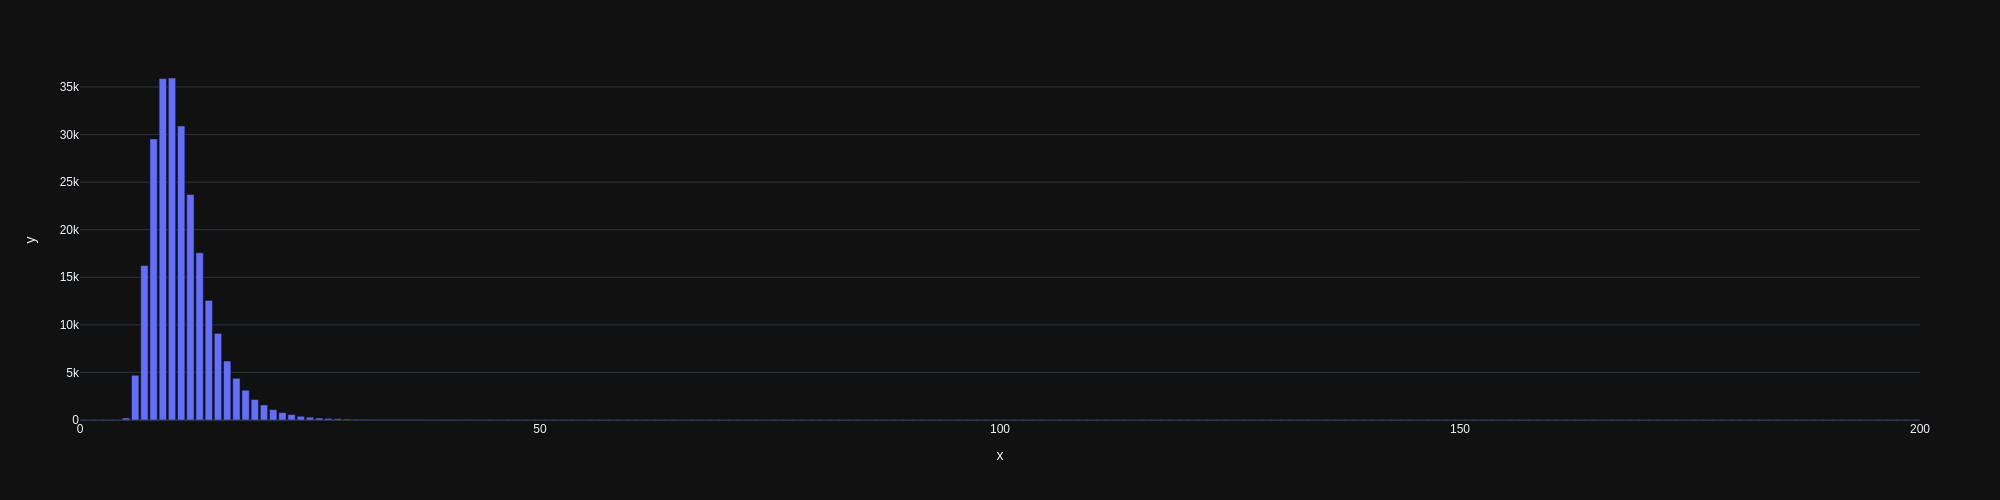

In [19]:
all_tokens = en_tokens_len.tolist()+es_tokens_len.tolist()
counts,bins = np.histogram(all_tokens,bins=np.linspace(0,500,501))
fig = px.bar(y=[0]+counts.tolist(),x=bins.tolist())
fig.update_xaxes(range=[0,200])
fig.show("png",width=2000)

In [20]:
MAX_TOKENS = 128
def prepare_ds(en,es):
    en = up_stream_processing(en,"en")
    es = up_stream_processing(es,"es")
    en = en[:,:MAX_TOKENS]
    es = es[:,:MAX_TOKENS]
    return (en.to_tensor(),es[:,:-1].to_tensor()),es[:,1:].to_tensor()

In [21]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
en_array = np.array(en_text)
es_array = np.array(es_text)
all_indices = np.random.uniform(size=len(en_text))
train_mask = all_indices <= 0.8
valid_mask = (all_indices > 0.8) & (all_indices <= 0.95)
test_mask = all_indices > 0.95
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[train_mask],es_array[train_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
valid_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[valid_mask],es_array[valid_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[test_mask],es_array[test_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)

In [22]:
for (en_in,es_in),tar_in in train_ds.take(1):
    print(en_in.shape,es_in.shape,tar_in.shape)

(64, 16) (64, 16) (64, 16)


# Transformers

In [23]:
class Shapecheck(tf.Module):

    def __init__(self,**kwargs):

        super(Shapecheck,self).__init__(**kwargs)
        self.shapes = {}

    def __call__(self,tensor,names:str):

        if not tf.executing_eagerly():
            return
        all_dimension_names = names.split()
        shape_of_tensor = tf.shape(tensor).numpy().tolist()
        if len(shape_of_tensor) != len(all_dimension_names):
            if len(shape_of_tensor) > len(all_dimension_names):
                raise ValueError(f"The shapes and dimensions don't match and tensor with shape {shape_of_tensor} has more dimensions than provided: {len(all_dimension_names)}")
            else:
                raise ValueError(f"The shapes and dimensions don't match and tensor with shape {shape_of_tensor} has less dimensions than provided: {len(all_dimension_names)}")

        else:
            for _shape,_name in zip(shape_of_tensor,all_dimension_names):
                if _name not in self.shapes:
                    self.shapes[_name] = _shape
                else:
                    if self.shapes[_name] == _shape:
                        continue
                    else:
                        raise ValueError(f"The given tensor with shape{shape_of_tensor} has a mismatch with dimension {_shape} with old dimension present {self.shapes[_name]}")

In [24]:
shape_check = Shapecheck()

shape_check(tf.ones(shape=[64,15,512]),"b s u")
shape_check(tf.ones(shape=[64,17,512]),"b t u")
shape_check(tf.ones(shape=[64,2,17,15]),"b n t s")
shape_check(tf.ones(shape=[64,15,15,512]),"b s s u")
shape_check.shapes

{'b': 64, 's': 15, 'u': 512, 't': 17, 'n': 2}

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

## Embedding and Positional Encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

- Given a sequence of tokens, both the input tokens (ENGLISH) and target tokens (SPANISH) have to be converted to vectors using a ```keras.layers.Embedding``` layer
- The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent layers or convolutional layers. It needs some way to idientify word order, otherwise is would see the input sequence as a bag of words for instance,
  - ```how are you```
  - ```you are how```
  - ```are you how```
  - ```you how are```

- A Transformer adds "Positional Encoding" to the embedding vectors. It uses a set of sines and consines at frequencies (across the sequence). By definition nearby elements will have similar position encodings

- The original paper uses the following formula for calculating the positional encoding:
$$ PE_{(pos,2i)} = sin\Biggl( \frac{pos}{10000^{\frac{2i}{d_{model}}}}\Biggr)$$

- The Original paper uses interleaving sines and cosines but we are going to concatenate it


In [25]:
EMBED_SIZE = 512

In [26]:
en_embedding = keras.layers.Embedding(len(en_vocab),EMBED_SIZE,mask_zero=True)
es_embedding = keras.layers.Embedding(len(spa_vocab),EMBED_SIZE,mask_zero=True)

In [27]:
def pos_encoding(length=2048,depth=EMBED_SIZE,casting:Literal["interleaving","concatenated"]="interleaving"):
    assert depth%2==0,f"The given depth: {depth} is not even please give even depth"
    pos = np.arange(depth//2)[np.newaxis,:]/(depth//2)
    positions = np.arange(length)[:,np.newaxis]
    angles_rads = positions * 1/(10000**pos)
    if casting == "concatenated":
        return tf.cast(np.concatenate([np.sin(angles_rads),np.cos(angles_rads)],axis=-1),tf.float32)
    else:
        embed = np.zeros(shape=[length,depth])
        print(embed.shape)
        embed[:,::2] = np.sin(angles_rads)
        embed[:,1::2] = np.cos(angles_rads)
        return tf.cast(embed,tf.float32)

(2048, 512)


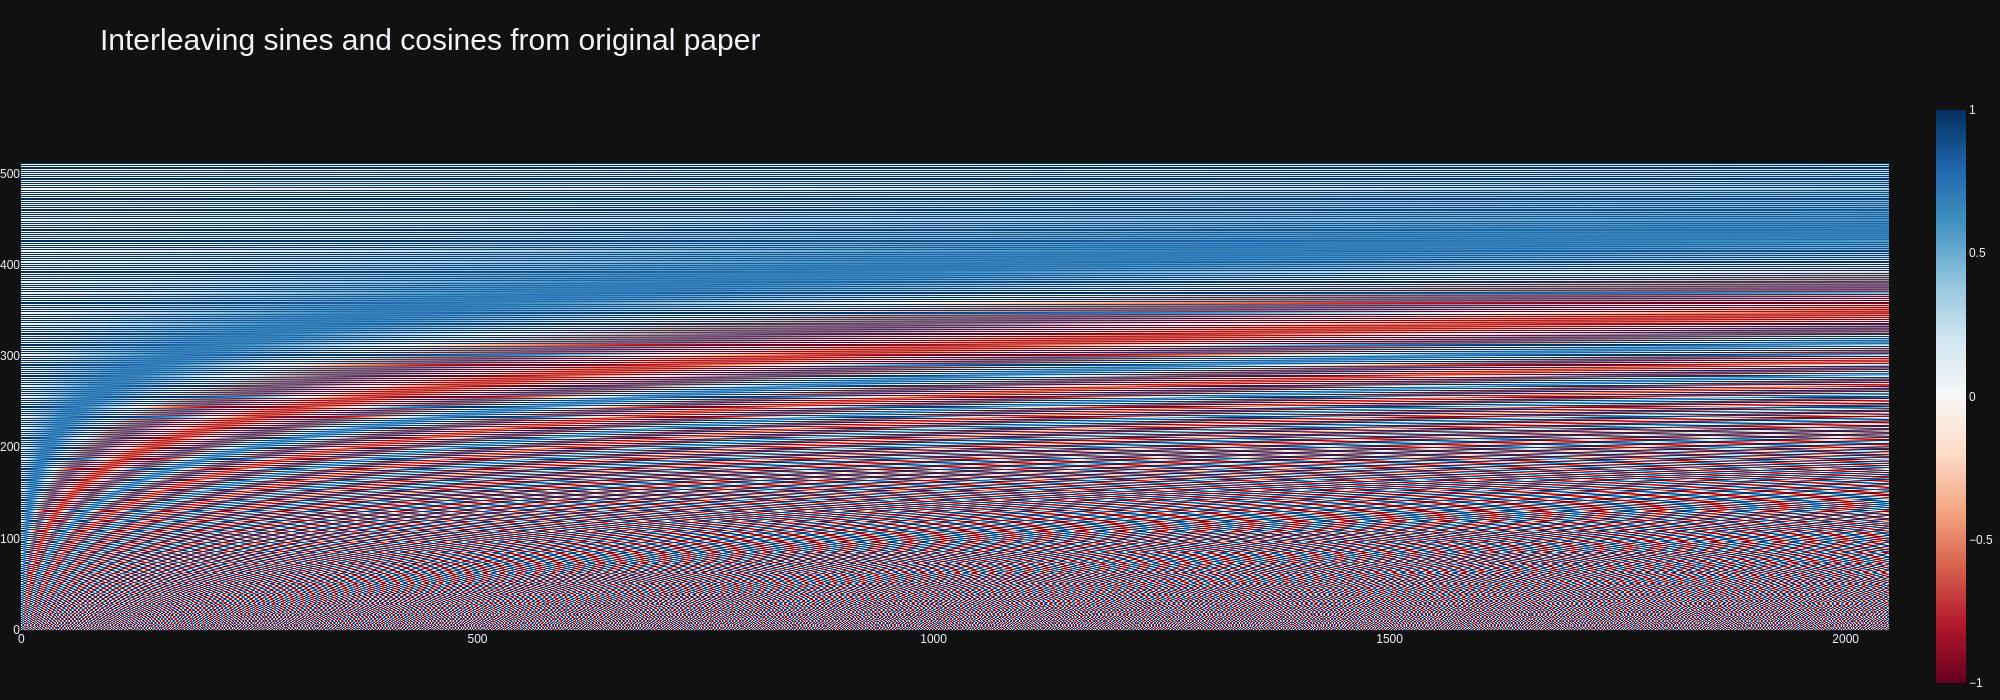

In [28]:
fig = px.imshow(img=pos_encoding(casting="interleaving").numpy().T,color_continuous_scale=px.colors.sequential.RdBu,origin="lower",title="Interleaving sines and cosines from original paper")
fig.update_layout(margin=dict(l=20,r=0,t=100,b=0),title=dict(font=dict(size=30)))
fig.show("png",width=2000,height=700)

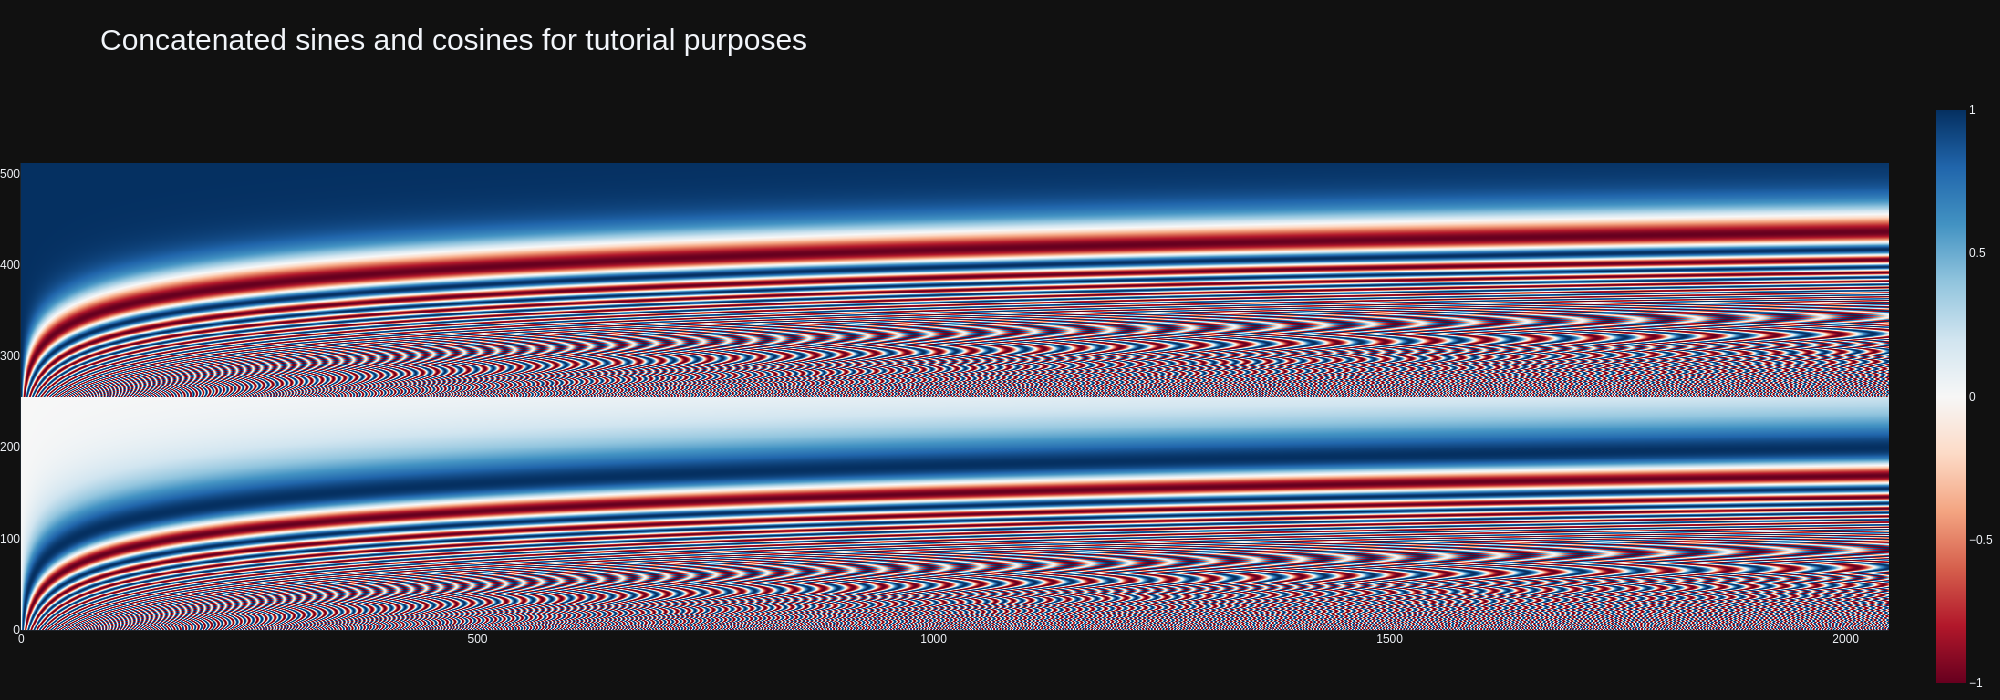

In [29]:
fig = px.imshow(img=pos_encoding(casting="concatenated").numpy().T,color_continuous_scale=px.colors.sequential.RdBu,origin="lower",title="Concatenated sines and cosines for tutorial purposes")
fig.update_layout(margin=dict(l=20,r=0,t=100,b=0),title=dict(font=dict(size=30)))
fig.show("png",width=2000,height=700)

In [30]:
pos_encode = pos_encoding(casting="concatenated")
pos_encode /= tf.norm(pos_encode,axis=1,keepdims=True)
d = pos_encode[1000]
res = tf.einsum("pd,d -> p",pos_encode,d)
print(pos_encode.shape,d.shape,res.shape)

(2048, 512) (512,) (2048,)


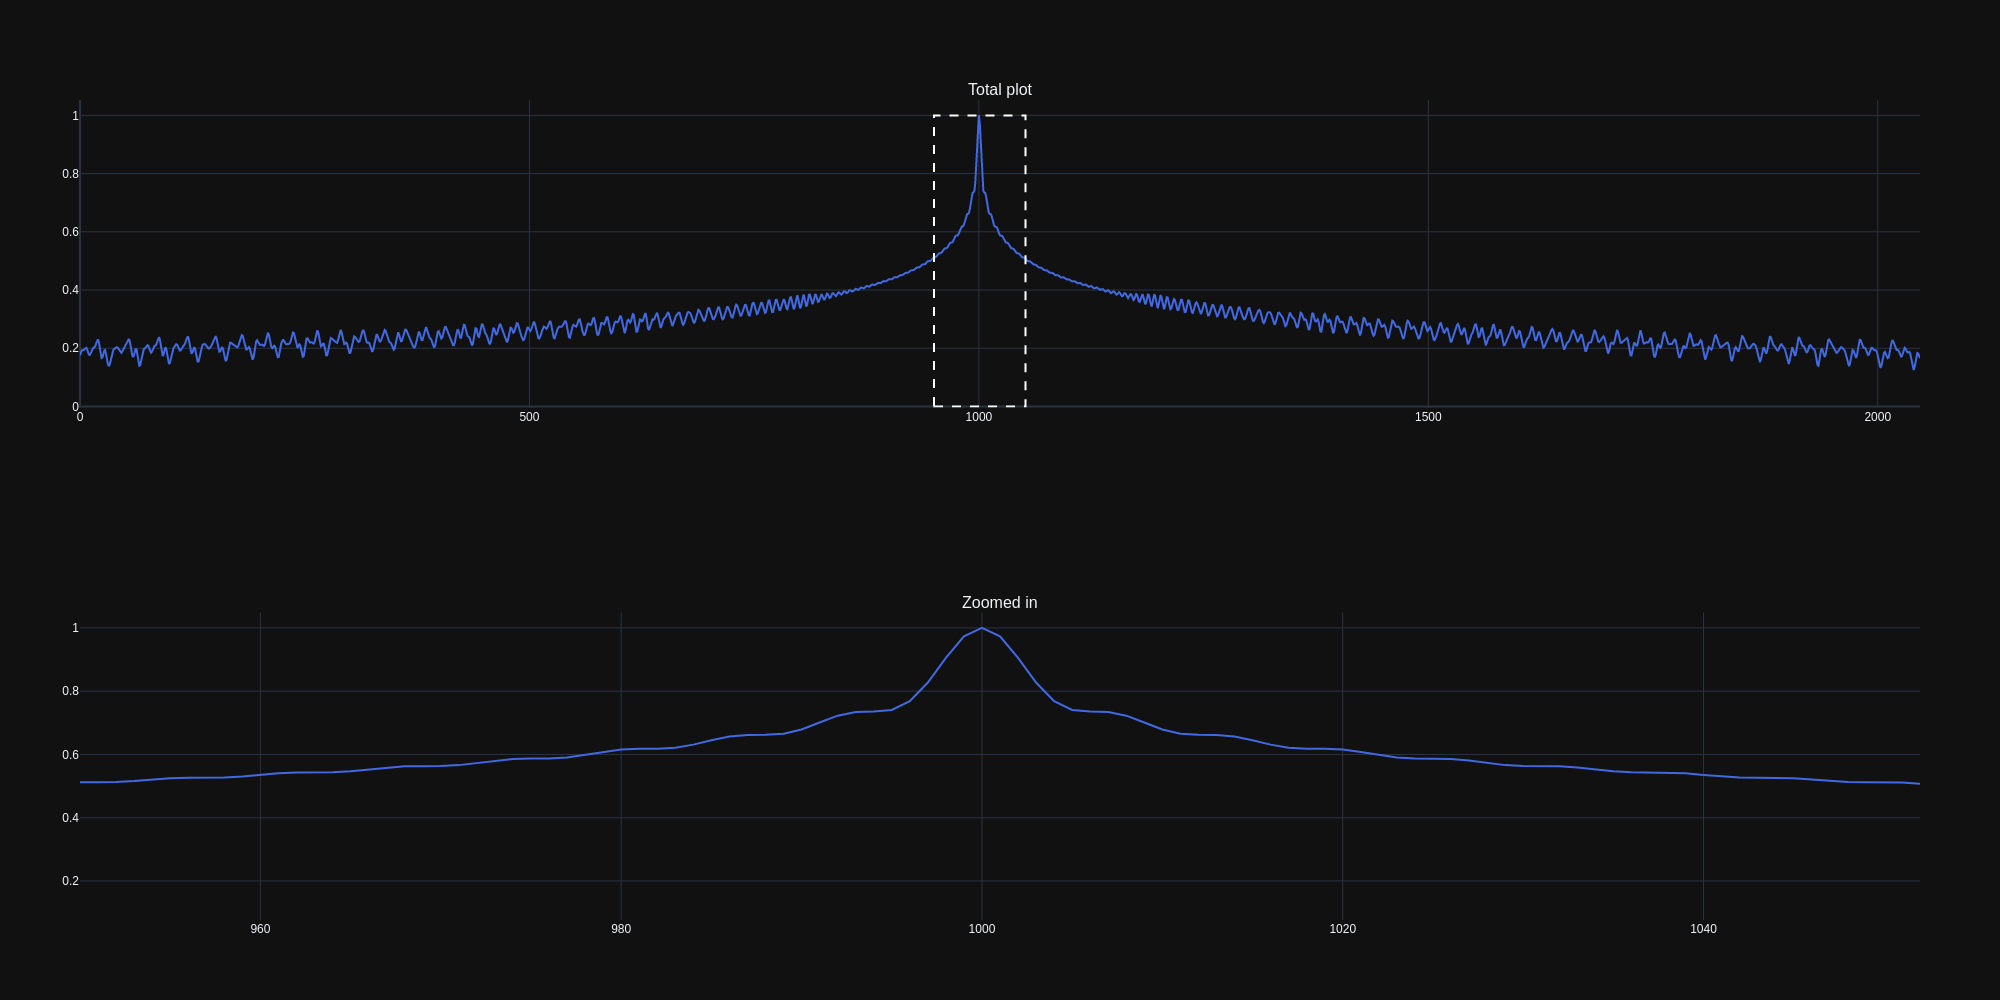

In [31]:
fig = make_subplots(rows=2,subplot_titles=["Total plot","Zoomed in"])
fig.add_trace(go.Scatter(y=res,mode="lines",line=dict(color="royalblue")),row=1,col=1)
fig.add_shape(type="rect",x0=950,x1=1052,y0=0,y1=1,line=dict(color="white",dash="dash"),row=1,col=1)
fig.add_trace(go.Scatter(y=res,mode="lines",line=dict(color="royalblue")),row=2,col=1)
fig.for_each_xaxis(lambda axes: axes.update(range=[950,1052]),row=2,col=1)
fig.update_layout(height=1000,showlegend=False)
fig.show("png",width=2000)

In [32]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self,vocab_size:int,embed_size:int=512,casting:Literal["concat","interleave"]="concat",length:int=2048,**kwargs):
        """
        Positional Encoding layer used in the initial layers of the transformers
        """
        super(PositionalEncoding,self).__init__(**kwargs)
        assert embed_size%2==0,f"EMBED_SIZE needs to be even"
        self.vocab_size = vocab_size
        self.embed_size = embed_size//2
        self.embedding = keras.layers.Embedding(vocab_size,embed_size,mask_zero=True)
        self.casting = casting
        self.length = length

    def call(self,encoder_inputs):
        # shape_checker = Shapecheck()
        seq_length = tf.shape(encoder_inputs)[1]
        # shape_checker(encoder_inputs,"batch encoder_sequence")
        embed_out = self.embedding(encoder_inputs)
        # shape_checker(embed_out,"batch encoder_sequence units")
        embed_out *= tf.sqrt(tf.cast(self.embed_size,tf.float32))
        embed_out += self._positional_encoding()[tf.newaxis,:seq_length,:]
        # shape_checker(embed_out,"batch encoder_sequence units")
        return embed_out



    def compute_mask(self,*args,**kwargs):
        return self.embedding.compute_mask(*args,**kwargs)


    def _positional_encoding(self):
        positions = tf.range(start=0,limit=self.length,dtype=tf.float32)[:,tf.newaxis]
        angles = tf.range(start=0,limit=self.embed_size,dtype=tf.float32)[tf.newaxis,:]
        angles /= self.embed_size
        angles = positions * (1/10000**angles)
        if self.casting == "interleave":
            embed = np.zeros(shape=[self.length,self.embed_size*2])
            embed[:,::2] = tf.sin(angles)
            embed[:,1::2] = tf.cos(angles)
            return tf.convert_to_tensor(embed)
        else:
            return tf.concat([tf.sin(angles),tf.cos(angles)],axis=-1)


en_embedding = PositionalEncoding(vocab_size=len(en_vocab))
es_embedding = PositionalEncoding(vocab_size=len(spa_vocab))

In [33]:
en_embed_out = en_embedding(en_in)
es_embed_out = es_embedding(es_in)

In [34]:
en_embed_out._keras_mask # Which is nothing but tf.cast(en_in,tf.bool)

<tf.Tensor: shape=(64, 16), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])>

## Add and Normalize blocks

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

- These Add and Norm blocks are scattered throughout the model. Each one joins a residual connection and run the result through a ```LayerNormalization``` layer.
- The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.
- The residual Add and norm layer blocks are included to make the training efficient. They ensure the gradients flow without dying and also ensures that the tensors are updated instead of replaced.
- The Implementation use add layer instead of + because the masks are propogated with layers

## The Base Attention Layer

- Attention layers are used throught the model. Theses are all identical except for how the attention is configured. Each one contains a    ```layers.MultiHeadAttention```<br>
```layers.LayerNormalization```<br>
```layers.Add```<br>
layers.
- To implement these attention layers, start with a simple base class that just contains the component layers. Sach us-case will be implemented as a subclass. its a more code to write this way,but it keeps the intention clear

In [35]:
class BaseAttention(keras.layers.Layer):

    def __init__(self,**kwargs):

        super(BaseAttention,self).__init__()
        self.base_attention = keras.layers.MultiHeadAttention(**kwargs)
        self.layer_norm = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

- This is how base attention looks like
1. The query sequence: The sequence which needs to be studied i.e., the sequence that needs to be lookedup
2. The context sequence: The sequence that is being used for the lookup

- The output has the same shape as the query-sequence
- The common comparision is that this operation is like a dictionary lookup . A fuzzy,differentiable,vectorized dictionary lookup
- Herers a regular python dictionry , with 3 keys and 3 values being passed a single query.
```python

d = {'color':'blue','age',:22,'type':'pickup'}
result = d['color']

```
-  - The ```query``` $\text{\sect}$ is what you're trying to find.
-  - The ```key```   $\text{\sect}$ is what sort of information the dictionary has.
-  - The ```value``` is that information
<br>
<br>
- When you lookup a ```query``` in a regular dictionary, the dictionary finds the matching ```key```,and return its associated ```value```. The ```query``` either has a matching ```key``` or it doesn't. You can imagine a fuzzy dictionary where the keys don't have to match perfectly. If you looked up d["sepcies] in the dictionary aboev, maybe you'd want it to return "pickup" since that's the best match for the query.
- An attentIon layer does a fuzzy lookpu like this but its not just looking for thue best key . It combines the values based on how well the query matches each key.
- How does that work? In an attention layer the query , key and value are each vectors.Instead of doing a hash lookup the attenttion layer combines the query and key vectors to determine how well they match, the "attention score".The layer return the average across all the values, weighted by the "attention scors"
- Each location the query-sequence provied a query vector. The context sequence acts as the dictonary. At each location in the context sequence provides a key and value vector .The input vectors are not used directly , the ```layers.MulitHeadAttention``` layer includes layers.Dense layers to project the input vecotort before using them

## The Cross Attention Layer

- At the literal center of the transformers is the cross attention layer which connects the encoder to decoder. This layer is the most straight-forward use of attention in the model,it performs the same task as the attention block in the NMT Tutorial

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

- To implement this you pass the target sequence x as the query and the context sequence as the key/value when calling the mha layer:

In [36]:
class CrossAttention(BaseAttention):

    def call(self,encoder_outputs,decoder_outputs):
        shape_checker = Shapecheck()
        # shape_checker(encoder_outputs,"batch encoder_sequence units")
        # shape_checker(decoder_outputs,"batch decoder_sequence units")
        attetnion_outputs,self.attention_scores = self.base_attention(query=decoder_outputs,key=encoder_outputs,value=encoder_outputs,return_attention_scores=True)
        # shape_checker(attetnion_outputs,"batch decoder_sequence units")
        # shape_checker(self.attention_scores,"batch num_heads decoder_sequence encoder_sequence")
        return self.layer_norm(self.add([attetnion_outputs,decoder_outputs]))

In [37]:
cross_attention = CrossAttention(num_heads=2,key_dim=512)
print(cross_attention(en_embed_out,es_embed_out).shape)
print(cross_attention.attention_scores.shape)

(64, 16, 512)
(64, 2, 16, 16)


## Global Self-Attention layer

- This layer is responsible for processing the context sequence, and propogating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

- Since the context sequence is fixed while the translation is being genreated, information is allowed to flow in both directions. Before Transformers and self attention, models commonly used RNN or CNN to this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

The RNN and CNN have their limitations.
- The Rnn allows information to flow all the way across the sequenc,but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provised a imited recptive field. The receptive field only grows linealry with the number fo CNN layers, You need to stack a number of Convolution layers to transmit information across the sequence ( Wavenet reduces this problem by using dilated convolutions)

In [38]:
class SelfAttention(BaseAttention):

    def call(self,encoder_outputs):
        # shape_check = Shapecheck()
        # shape_check(encoder_outputs,"batch encoder_sequence units")
        attention_output,self.attention_scores = self.base_attention(query=encoder_outputs,key=encoder_outputs,value=encoder_outputs,return_attention_scores=True)
        # shape_check(attention_output,"batch encoder_sequence units")
        # shape_check(self.attention_scores,"batch num_heads encoder_sequence encoder_sequence")
        return self.layer_norm(self.add([attention_output,encoder_outputs]))

In [39]:
self_attention = SelfAttention(num_heads=2,key_dim=512)

In [40]:
print(self_attention(en_embed_out).shape)
print(self_attention(en_embed_out).shape)

(64, 16, 512)
(64, 16, 512)


Sticking with the same style as before you could draw it like this

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

## The Causal(Masked) Self Attention Layer

- This needs to be handled differently from the encoder's global self attention layer.
- Like the text generation tutorial and the NMT with attention tutorial, Transformers are an "Autoreggressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each seuquence elment only depends on the previous sequence elments; the models are called ```causal```

- A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use ```layers.Conv1D(padding="causal")```)

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways:

1. In training, it lets you compute loss for every location in the output sequence whiele executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.

    - For an RNN you just need the RNN-state to account for previous computations (pass return_state=True to the RNN layer's constructor)
    - For a CNN you would need to follow the approach of Fast Wavenet

To build a causal self attention layer,you need to ues an approprate mask when compution the attention scorse and summing the attention values<br>
This is taken care of automatically if you pass use_causal_mask = True to the MultiHeadAtttenion layer when you call it

In [41]:
class CausalSelfAttention(BaseAttention):

    def call(self,decoder_inputs):
        # shape_check = Shapecheck()
        # shape_check(decoder_inputs,"batch decoder_sequence units")
        attention_outputs,self.attention_scores = self.base_attention(query=decoder_inputs,key=decoder_inputs,value=decoder_inputs,return_attention_scores=True,use_causal_mask=True)
        # shape_check(attention_outputs,"batch decoder_sequence units")
        # shape_check(self.attention_scores,"batch num_heads decoder_sequence decoder_sequence")
        return self.layer_norm(self.add([attention_outputs,decoder_inputs]))


In [42]:
masked_self_attention = CausalSelfAttention(num_heads=1,key_dim=512)
print(masked_self_attention(es_embed_out).shape)

(64, 16, 512)


The causal mask ensures that each location has only access to the locations that come before it

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>
<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

In [43]:
csa = CausalSelfAttention(num_heads=1,key_dim=512)
print(csa(self_attention(en_embed_out)).shape)

(64, 16, 512)


## FeedForward

The transformed also includes this point-wise feed-forward network in both the encoder and decoder

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

This network consists of two linear layers ```keras.layers.Dense``` with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalizaiton

In [44]:
class FeedForward(keras.layers.Layer):

    def __init__(self,length:int,d_model:int,dropout_rate=0.1,**kwargs):

        super(FeedForward,self).__init__()
        self.ff = keras.Sequential([
            keras.layers.Dense(length,"relu"),
            keras.layers.Dense(d_model),
            keras.layers.Dropout(dropout_rate)
        ])
        self.add = keras.layers.Add()
        self.layer_norm = keras.layers.LayerNormalization()

    def call(self,attention_outputs):

        # shape_check = Shapecheck()
        # shape_check(attention_outputs,"batch encoder_sequence units")
        ff_out = self.ff(attention_outputs)
        # shape_check(ff_out,"batch encoder_sequence d_model")
        return self.layer_norm(self.add([attention_outputs,ff_out]))

In [45]:
feed_forward = FeedForward(length=2048,d_model=512)
print(feed_forward(self_attention(en_embed_out)).shape)

(64, 16, 512)


# Encoder Layer

The encoder contains a stack of N encoder layers. Where each ```EncoderLayer``` contains ```GlobalSelfAttention``` and ```FeedForward``` laye

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

In [46]:
class Encoder(keras.layers.Layer):

    def __init__(self,vocab_size:int,length=2048,d_model=512,casting:Literal["concat","interleave"]="concat",self_num_heads=3,embed_dropout_rate=0.1,feed_dropout_rate=0.1,N=4,**kwargs):

        super(Encoder,self).__init__(**kwargs)
        self.num_layers = N
        self.pos_encode = PositionalEncoding(vocab_size,d_model,casting=casting,length=length)
        self.drop_out = keras.layers.Dropout(embed_dropout_rate)
        self.self_attention = SelfAttention(num_heads=self_num_heads,key_dim=d_model)
        self.feed_forward = FeedForward(length,d_model,feed_dropout_rate)


    def call(self,encoder_inputs):

        # shape_check = Shapecheck()
        # shape_check(encoder_inputs,"batch encoder_sequence")
        z = self.drop_out(self.pos_encode(encoder_inputs))
        # shape_check(z,"batch encoder_sequence units")
        for _ in range(self.num_layers):
            z = self.feed_forward(self.self_attention(z))
        return z

In [47]:
en_encoder = Encoder(vocab_size=len(en_vocab))
print(en_encoder(en_in).shape)

(64, 16, 512)


In [48]:
class Decoder(keras.layers.Layer):

    def __init__(self,vocab_size:int,length=2048,d_model=512,casting:Literal["concat","interleave"]="concat",N=12,self_num_heads=3,cross_num_heads=3,feed_dropout_rate=0.1,embed_dropout_rate=0.1,**kwargs):

        super(Decoder,self).__init__(**kwargs)

        self.num_layers = N
        self.pos_encode = PositionalEncoding(vocab_size,d_model)
        self.dropout = keras.layers.Dropout(embed_dropout_rate)
        self.self_attention = SelfAttention(num_heads=self_num_heads,key_dim=d_model)
        self.cross_attention = CrossAttention(num_heads=cross_num_heads,key_dim=d_model)
        self.feed_forward = FeedForward(length,d_model,feed_dropout_rate)


    def call(self,decoder_inputs,encoder_outputs):

        shape_check = Shapecheck()
        shape_check(decoder_inputs,"batch decoder_sequence")
        z = self.dropout(self.pos_encode(decoder_inputs))
        shape_check(z,"batch decoder_sequnce units")

        for _ in range(self.num_layers):
            z = self.self_attention(z)
            z = self.cross_attention(z,encoder_outputs)
            z = self.feed_forward(z)

        return z

In [49]:
es_decoder = Decoder(vocab_size=len(spa_vocab))
print(es_decoder(es_in,en_encoder(en_in)).shape)

(64, 16, 512)


In [50]:
class Translator(keras.Model):

    def __init__(
            self,
            encoder_vocab_size:int,
            decoder_vocab_size:int,
            encoder_units:int,
            decoder_units:int,
            encoder_length=2048,
            decoder_length=2048,
            encoder_embed_depth=512,
            decoder_embed_depth=512,
            encoder_pos_dropout_rate=0.1,
            decoder_pos_dropout_rate=0.1,
            encoder_self_attention_num_heads=3,
            decoder_self_attention_num_heads=3,
            decoder_cross_attention_num_heads=3,
            encoder_feed_forward_dropout_rate=0.1,
            decoder_feed_forward_dropout_rate=0.1,
            encoder_feed_forward_units=2048,
            decoder_feed_forward_units=2048,
            encoder_casting:Literal["concat","interleave"]="concat",
            decoder_casting:Literal["concat","interleave"]="concat",
            **kwargs
    ):

        super(Translator,self).__init__(**kwargs)

        """
        Variables Instantiations
        """
        self.encoder_units = encoder_units
        self.decoder_units = decoder_units
        """
        Layers Instantiations
        """
        self.encoder_embedder = PositionalEncoding(encoder_vocab_size,encoder_embed_depth,casting=encoder_casting,length=encoder_length)
        self.decoder_embedder = PositionalEncoding(decoder_vocab_size,decoder_embed_depth,casting=decoder_casting,length=decoder_length)
        self.encoder_self_attention = keras.layers.MultiHeadAttention(encoder_self_attention_num_heads,key_dim=encoder_embed_depth)
        self.decoder_masked_self_attention = keras.layers.MultiHeadAttention(decoder_self_attention_num_heads,key_dim=decoder_embed_depth)
        self.decoder_cross_attention = keras.layers.MultiHeadAttention(decoder_cross_attention_num_heads,key_dim=decoder_embed_depth)
        self.encoder_feed_forward = keras.Sequential([
            keras.layers.Dense(encoder_feed_forward_units,"relu"),
            keras.layers.Dense(encoder_embed_depth),
            keras.layers.Dropout(encoder_feed_forward_dropout_rate)
        ])
        self.decoder_feed_forward = keras.Sequential([
            keras.layers.Dense(decoder_feed_forward_units,"relu"),
            keras.layers.Dense(decoder_embed_depth),
            keras.layers.Dropout(decoder_feed_forward_dropout_rate)
        ])
        self.add_and_layer_norm = keras.Sequential([
            keras.layers.Add(),
            keras.layers.LayerNormalization()
        ])

        self.out = keras.layers.Dense(decoder_vocab_size)



    def call(self,inputs):
        z_enc = self.encoder_embedder(inputs[0])

        for _ in range(self.encoder_units):

            z_copy = z_enc
            z_enc = self.encoder_self_attention(query=z_enc,key=z_enc,value=z_enc)
            z_enc = self.add_and_layer_norm([z_copy,z_enc])
            z_copy = z_enc
            z_enc = self.encoder_feed_forward(z_enc)
            z_enc = self.add_and_layer_norm([z_copy,z_enc])


        z_dec = self.decoder_embedder(inputs[1])

        for _ in range(self.decoder_units):

            z_copy = z_dec
            z_dec = self.decoder_masked_self_attention(query=z_dec,key=z_dec,value=z_dec,use_causal_mask=True)
            z_dec = self.add_and_layer_norm([z_copy,z_dec])
            z_copy = z_dec
            z_dec = self.decoder_cross_attention(query=z_dec,key=z_enc,value=z_enc)
            z_dec = self.add_and_layer_norm([z_copy,z_dec])
            z_copy = z_dec
            z_dec = self.decoder_feed_forward(z_dec)
            z_dec = self.add_and_layer_norm([z_copy,z_dec])

        z_dec = self.out(z_dec)
        try:
            del z_dec._keras_mask
        except AttributeError:
            pass
        return z_dec


In [54]:
class CustomLR(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self,d_model=512,warmup_steps=4000,**kwargs):

        super(CustomLR,self).__init__(**kwargs)
        self.d_model = tf.math.rsqrt(tf.cast(d_model,tf.float32))
        self.warmup_steps = tf.cast(warmup_steps,tf.float32)


    def __call__(self,step):
        step = tf.cast(step,tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = (self.warmup_steps ** -1.5) * (step)
        return self.d_model * tf.minimum(arg1,arg2)


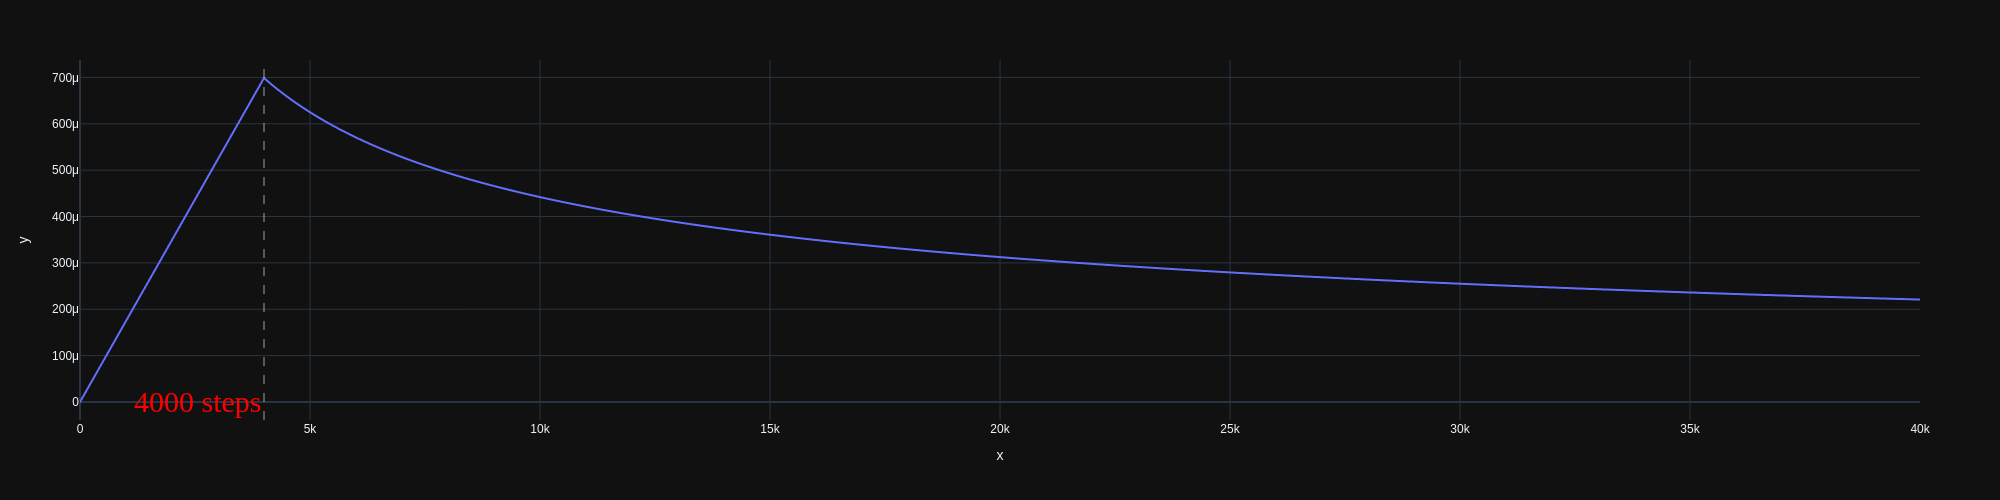

In [55]:
learning_rate = CustomLR()
fig = px.line(x=tf.range(40000).numpy(),y=learning_rate(tf.range(40000)).numpy())
fig.add_vline(x=4000,line=dict(dash="dash",color="rgba(255,255,255,0.3)"),annotation_text="4000 steps",annotation_position="bottom left",annotation_font_size=30,annotation_font_family="Fira Code",annotation_font_color="red")
fig.show("png",width=2000)

In [56]:
def custom_loss(y_true,y_pred):
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")
    loss = loss_fn(y_true,y_pred)
    mask = tf.cast(y_true != 0,loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [82]:
def custom_metric(y_true,y_pred):
    y_pred = tf.cast(tf.argmax(y_pred,axis=-1),y_true.dtype)
    mask = y_true != 0
    accuracy = y_true == y_pred
    accuracy = accuracy & mask
    return tf.reduce_sum(tf.cast(accuracy,tf.float32))/tf.reduce_sum(tf.cast(mask,tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [84]:
model.evaluate(valid_ds)

282/282 [==============================] - 1825s 6s/step - loss: 8.5777 - custom_metric: 2.3554e-05 - custom_loss: 8.5777


[8.577741622924805, 2.355355172767304e-05, 8.57772445678711]

In [85]:
1/(len(spa_vocab))

0.0002053388090349076

## As you can see they are randomized the evaluated accuracy should be equal to 1/len(spa_vocab)